# Hisense 01XHY.H infrared controller

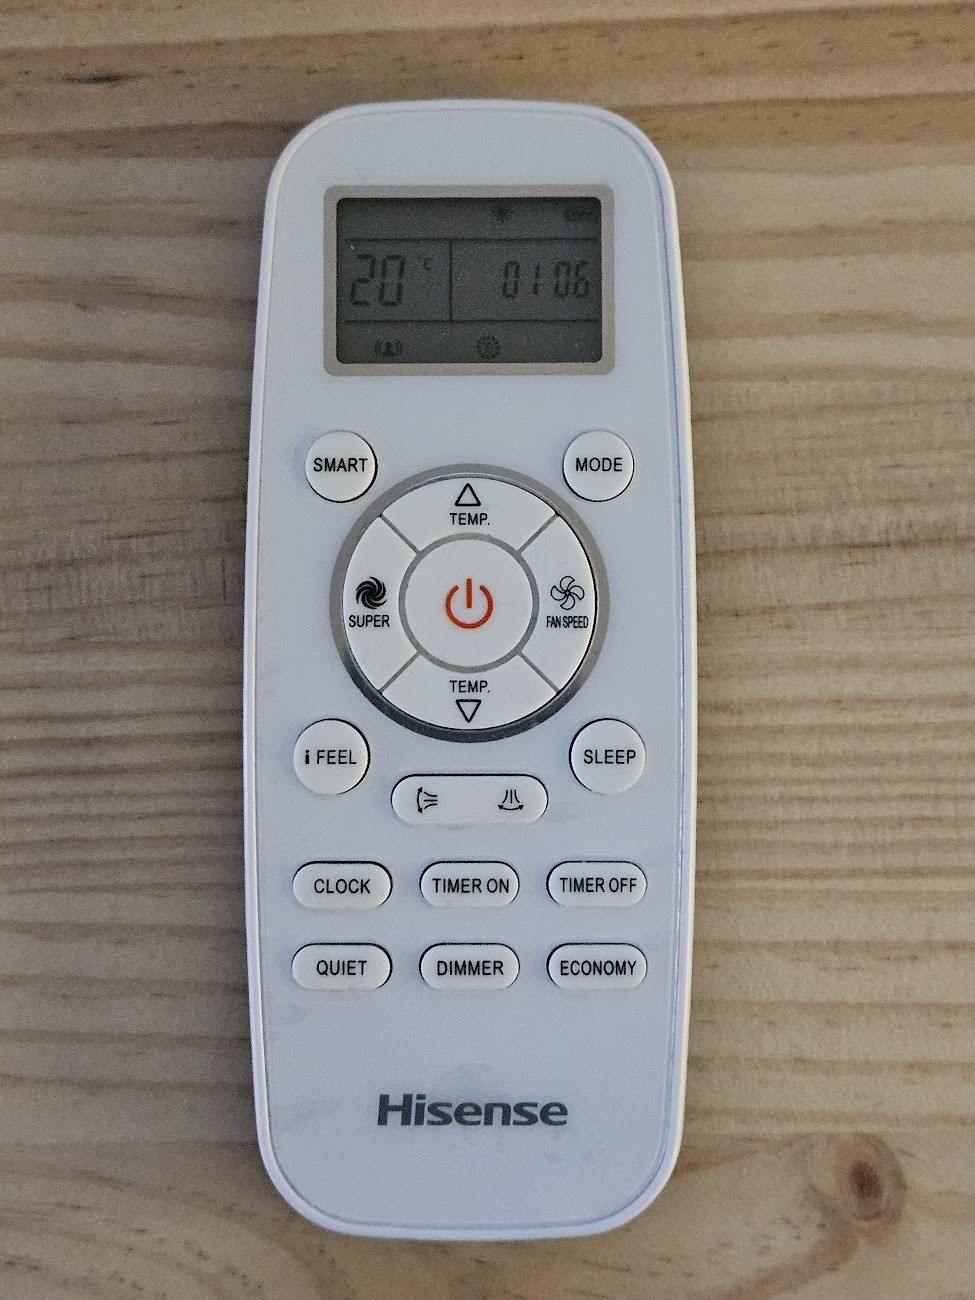

## iFeel sensor temp IR code generation

### Hisense IR Control Protocol
Signals shown in the following sections transmitted by the Hisense control have been captured by the Broadlink RM4-mini device. 

### 1. Physical layer protocol

The ir-control signals received by the rm4-mini are represented as a sequence of bytes, where the value of every byte represents the elapsed time between two consecutive IR pulses, as suggested in [this article.](https://www.instructables.com/Reverse-engineering-of-an-Air-Conditioning-control/)

In [1]:
import json
import base64
import pandas as pd

pd.set_option('display.max_columns', 20)
pd.set_option('display.expand_frame_repr', False)

with open('codes.json', 'r') as f:
    codes = json.load(f)

bytes_sequence = base64.b64decode(codes['heat']['auto']['18'])
bytes_sequence

b'&\x00\\\x01\x00\x01\x1d\x90\x126\x117\x11\x12\x11\x12\x12\x11\x12\x12\x11\x13\x117\x10\x12\x126\x117\x11\x12\x11\x13\x11\x12\x11\x12\x12\x12\x11\x12\x11\x12\x11\x12\x12\x11\x12\x11\x12\x11\x12\x13\x11\x12\x11\x12\x10\x13\x11\x12\x11\x12\x11\x12\x118\x10\x13\x12\x11\x12\x11\x11\x12\x11\x13\x10\x13\x10\x13\x11\x12\x12\x12\x11\x12\x11\x12\x11\x12\x11\x12\x11\x13\x11\x12\x11\x12\x12\x11\x12\x12\x11\xff\x11\x13\x10\x12\x11\x12\x11\x13\x11\x12\x11\x12\x12\x12\x117\x11\x12\x116\x12\x12\x117\x107\x127\x11\x13\x10\x13\x10\x12\x12\x11\x12\x11\x12\x11\x12\x13\x10\x13\x10\x13\x12\x11\x12\x11\x12\x11\x12\x12\x11\x12\x11\x12\x11\x13\x11\x12\x12\x11\x12\x11\x11\x13\x10\x13\x10\x13\x10\x13\x12\x11\x12\x12\x11\x13\x10\x13\x10\x12\x11\x12\x12\x11\x12\x12\x11\x12\x12\x12\x117\x12\x11\x11\x12\x117\x117\x116\x12\x12\x11\x13\x11\x12\x11\x12\x107\x127\x10\x13\x10\x13\x11\x12\x12\x12\x11\x11\x12\xff\x12\x11\x12\x12\x10\x13\x10\x13\x11\x12\x12\x12\x11\x12\x11\x12\x117\x11\x12\x126\x117\x11\x12\x11\x13\x11\x1

This is the same `bytes_sequence` represented by their integer values in a dataframe where the header its the byte position and the row 0 the byte value.

In [2]:
import pandas as pd
int_sequence = pd.DataFrame(list(bytes_sequence))
int_sequence.transpose()

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,38,0,92,1,0,1,29,144,18,54,...,17,19,16,19,17,18,17,0,13,5


Following the method proposed in [mentioned article](https://www.instructables.com/Reverse-engineering-of-an-Air-Conditioning-control/), as times between pulses might not be exact according to small inaccuracies, I've represented in an histogram to check how they group around specific values.

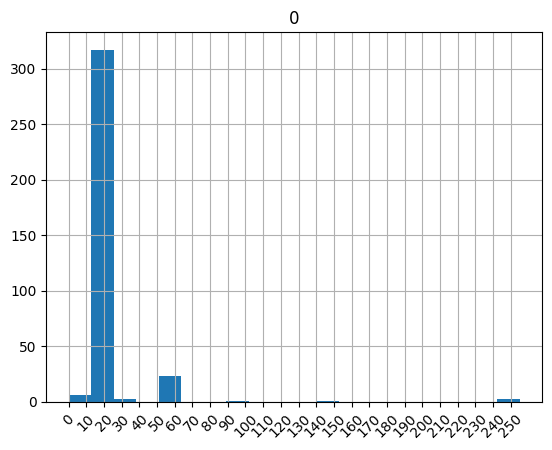

In [3]:
ax = int_sequence.hist(bins=20)
for a in ax.flatten():
    a.set_xticks(range(min(int_sequence[0]), max(int_sequence[0]) + 1, 10))  # Adjust step as needed
    a.set_xticklabels(a.get_xticks(), rotation=45)


It looks like most values can be found around ~20 and ~55, so first, all values around these are rounded to 20 and 55

In [4]:
def round_value(value):
    if 14 <= value <= 23:
        return 20
    elif 50 <= value <= 60:
        return 55
    return value
int_sequence['rounded'] = int_sequence[0].map(round_value)
int_sequence.transpose()

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,38,0,92,1,0,1,29,144,18,54,...,17,19,16,19,17,18,17,0,13,5
rounded,38,0,92,1,0,1,29,144,20,55,...,20,20,20,20,20,20,20,0,13,5


There are still some remaining values which haven't been rounded as their weren't close to the two most comon values. Looking at where those are placed in the whole sequence, it seems that they are located at the beginning or at the end of the sequence, so it looks like they are part of an initialization or ending sequence. Except for two of them, whose value is 255 and located within the byte in position 105 and the one in position 235 as shown in the following table.

In [5]:
int_sequence[(int_sequence['rounded'] != 20) & (int_sequence['rounded'] != 55)].transpose()

,0,1,2,3,4,5,6,7,105,235,349,350,351
0,38,0,92,1,0,1,29,144,255,255,0,13,5
rounded,38,0,92,1,0,1,29,144,255,255,0,13,5


Lets compare multiple codes to check whether this happens in all of them or its just noise of this particular code.

In [6]:
import numpy

sample = [list(base64.b64decode(c)) for c in codes['heat']['auto'].values()]
sample_df = pd.DataFrame(sample).map(round_value)
ns_values = sample_df.map(lambda x: x if x not in [55, 20] else numpy.nan)
ns_values.dropna(axis=1, how='all')

,0,1,2,3,4,5,6,7,105,106,...,237,238,239,349,350,351,352,353,354,355
0,38,0,92,1,0,1,29,144,255,NaN,...,NaN,NaN,NaN,0.0,13.0,5.0,NaN,NaN,NaN,NaN
1,38,0,94,1,0,1,30,144,255,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,13.0,5.0,NaN,NaN
2,38,0,94,1,0,1,30,144,0,1.0,...,255.0,NaN,NaN,NaN,NaN,0.0,13.0,5.0,NaN,NaN
3,38,0,92,1,0,1,29,144,255,NaN,...,NaN,NaN,NaN,0.0,13.0,5.0,NaN,NaN,NaN,NaN
4,38,0,94,1,0,1,30,144,255,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,13.0,5.0,NaN,NaN
5,38,0,94,1,0,1,30,143,255,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,13.0,5.0,NaN,NaN
6,38,0,94,1,0,1,29,144,255,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,13.0,5.0,NaN,NaN
7,38,0,94,1,0,1,29,144,0,1.0,...,255.0,NaN,NaN,NaN,NaN,0.0,13.0,5.0,NaN,NaN
8,38,0,96,1,0,1,29,145,0,1.0,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,0.0,13.0,5.0
9,38,0,96,1,0,1,31,143,0,1.0,...,0.0,1.0,0.0,NaN,NaN,NaN,NaN,0.0,13.0,5.0


Ok, it looks like most of the codes follow the patterns found on the example with some small differences. First, initial sequence its almost identical for all of them except for the second code. However, the ending sequence, even if matching identically in values, differ in positions between different codes. This may be explained by the middle "strange" values. In the example, there were two `[255]` values at positions __105__ and __235__. When comparing with different codes, it looks like the `[255]` value is sometimes replaced by a `[0, 1, 0]` sequence and so the whole sequence length varies accordingly. Those `[0, 1, 0]` subsequences are also located starting at __105__ and __237__ positions, so by now they will be treated as `[255]` values in a single position. I assume that those values/sequences act just as segment separators without any specific meaning. The following table show codes where segment separators being `[0, 1, 0]` have been replaced to `[255]`.

In [7]:
init_sequence = [0, 8]
payload_1 = [8, 104]
payload_2 = [106, 234]
payload_3 = [236, 348]

def normalize_values(row):
    if row[105] < 200:
        row[105] = 255
        row.pop(106)
        row.pop(106)
    if row[235] < 200:
        row[235] = 255
        row.pop(236)
        row.pop(236)
    return row

normalized_df = pd.DataFrame([normalize_values(list(sample_df.iloc[i, :])) for i in range(len(sample_df))])
normalized_df

,0,1,2,3,4,5,6,7,8,9,...,346,347,348,349,350,351,352,353,354,355
0,38.0,0.0,92.0,1.0,0.0,1.0,29.0,144.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN
1,38.0,0.0,94.0,1.0,0.0,1.0,30.0,144.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN
2,38.0,0.0,94.0,1.0,0.0,1.0,30.0,144.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN
3,38.0,0.0,92.0,1.0,0.0,1.0,29.0,144.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN
4,38.0,0.0,94.0,1.0,0.0,1.0,30.0,144.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN
5,38.0,0.0,94.0,1.0,0.0,1.0,30.0,143.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN
6,38.0,0.0,94.0,1.0,0.0,1.0,29.0,144.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN
7,38.0,0.0,94.0,1.0,0.0,1.0,29.0,144.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN
8,38.0,0.0,96.0,1.0,0.0,1.0,29.0,145.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN
9,38.0,0.0,96.0,1.0,0.0,1.0,31.0,143.0,20.0,55.0,...,20.0,20.0,20.0,0.0,13.0,5.0,NaN,NaN,NaN,NaN


So, with these considerations, it looks that the sequences have 7 parts:

- Initial sequence with the form: `[38, 0, 94, 1, 0, 1, 30, 144]`
- Payload between positions __8__ and __105__
- Separator 1: `[255]` value at __105__ position
- Payload between positions __106__ and __235__.
- Separator 2: `[255]` value at __235__ position
- Payload between positions __236__ and __349__.
- Ending sequence: `[0, 13, 5]` starting at position __349__ and to the end.

Considering that the meaninful data its composed by the payload sequences, we have:

- Payload 1: between positions __8__ and __105__: __97 bytes__
- Payload 2: between positions __106__ and __235__: __129 bytes__
- Payload 3: between positions ___236___ and __349__: __113 bytes__

From the payload sequences and their lengths, they all are 8's multiple plus one. As stated in the article [the article](https://www.instructables.com/Reverse-engineering-of-an-Air-Conditioning-control/), this is also probably because 'non-significative' pulse times are alternated between 'significative' pulse times. So in this case, assuming the higher value (55) means 1 and the lower (20) means 0, we would always have another 20 between all the rest of 20's and 55's. So a raw sequence and its equivalence would be:

```
20 20 20 55 20 55 20 20 20 55
-   0 -   1  -  1  -  0  -  1
```

This would also mean, that the 'strange' values of `[255]` acting as separators of segments could be preceded as well by their corresponding 'non-significative' pulse times of `[20]`, meaning that all payload sequences would end one position earlier, making all of them multiples of 8 also after removing 'non-significative' values. So:

- Payload 1: between positions 8 and 104: length = 96 --> significative values: 48 -> 6 bytes
- Payload 2: between positions 106 and 234: length = 128 --> significative values: 64 -> 8 bytes
- Payload 3: between positions 236 and 348: length = 112 -> significative values: 56 -> 7 bytes

So it seems that the payload has a total of `21 bytes`.

Following table shows values where init, ending and separator sequences have been removed to keep just payload data.

In [8]:
def clean_row(row):
    return (
        row[payload_1[0]:payload_1[1]] 
        + row[payload_2[0]:payload_2[1]] 
        + row[payload_3[0]:payload_3[1]]
    )

payloads_df = pd.DataFrame([clean_row(list(normalized_df.iloc[i, :])) for i in range(len(normalized_df))])
payloads_df

,0,1,2,3,4,5,6,7,8,9,...,326,327,328,329,330,331,332,333,334,335
0,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
1,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
2,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
3,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
4,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
5,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
6,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
7,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
8,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
9,20.0,55.0,20.0,55.0,20.0,20.0,20.0,20.0,20.0,20.0,...,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0


Then, non significative values have been removed to keep with just values equivalent to ones or zeros.

In [9]:
def remove_non_significative_values(df):
    return pd.DataFrame([[int(df.iloc[i,j]) for j in range(len(df.iloc[i,:])) if j%2 !=0] for i in range(len(df))])

meaning_df = remove_non_significative_values(payloads_df)
meaning_df

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20
1,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20
2,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20
3,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20
4,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20
5,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20
6,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20
7,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20
8,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20
9,55,55,20,20,20,20,20,55,20,55,...,20,20,55,20,55,20,20,20,20,20


Values converted to bits are shown below:

In [10]:
def convert_to_bits(df):
    return df.replace({55: 1, 20:0})

bits_df = convert_to_bits(meaning_df)
bits_df

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
2,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
3,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
4,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
5,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
6,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
7,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
8,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0
9,1,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


And bits grouped in bytes:

In [11]:
pd.set_option('display.max_columns', 10)
def group_into_8_bits(df):
    def group_row(row):
        byte_seq = []
        byte = ''
        for i, bit in enumerate(row):
            byte += str(bit)
            if (i+1) % 8 == 0:
                byte_seq.append(byte)
                byte = ''
        return byte_seq
    return pd.DataFrame(list(df.apply(group_row, axis=1)))

grouped_bits_df = group_into_8_bits(bits_df)
grouped_bits_df

,0,1,2,3,4,...,16,17,18,19,20
0,11000001,01100000,00000000,00000100,00000000,...,00000000,00000000,00010000,00000000,10100000
1,11000001,01100000,00000000,00001100,00000000,...,00000000,00000000,00010000,00000000,10100000
2,11000001,01100000,00000000,00000010,00000000,...,00000000,00000000,00010000,00000000,10100000
3,11000001,01100000,00000000,00001010,00000000,...,00000000,00000000,00010000,00000000,10100000
4,11000001,01100000,00000000,00000110,00000000,...,00000000,00000000,00010000,00000000,10100000
5,11000001,01100000,00000000,00001110,00000000,...,00000000,00000000,00010000,00000000,10100000
6,11000001,01100000,00000000,00000001,00000000,...,00000000,00000000,00010000,00000000,10100000
7,11000001,01100000,00000000,00001001,00000000,...,00000000,00000000,00010000,00000000,10100000
8,11000001,01100000,00000000,00000101,00000000,...,00000000,00000000,00010000,00000000,10100000
9,11000001,01100000,00000000,00001101,00000000,...,00000000,00000000,00010000,00000000,10100000


Also, its been noticed that bits are represented in LSB-first (least signigicant bit first) so to represent byte values properly, bits must be reversed:

In [12]:
def reverse_bits(df):
    return df.map(lambda x: x[::-1])

reversed_bits_df = reverse_bits(grouped_bits_df)
reversed_bits_df

,0,1,2,3,4,...,16,17,18,19,20
0,10000011,00000110,00000000,00100000,00000000,...,00000000,00000000,00001000,00000000,00000101
1,10000011,00000110,00000000,00110000,00000000,...,00000000,00000000,00001000,00000000,00000101
2,10000011,00000110,00000000,01000000,00000000,...,00000000,00000000,00001000,00000000,00000101
3,10000011,00000110,00000000,01010000,00000000,...,00000000,00000000,00001000,00000000,00000101
4,10000011,00000110,00000000,01100000,00000000,...,00000000,00000000,00001000,00000000,00000101
5,10000011,00000110,00000000,01110000,00000000,...,00000000,00000000,00001000,00000000,00000101
6,10000011,00000110,00000000,10000000,00000000,...,00000000,00000000,00001000,00000000,00000101
7,10000011,00000110,00000000,10010000,00000000,...,00000000,00000000,00001000,00000000,00000101
8,10000011,00000110,00000000,10100000,00000000,...,00000000,00000000,00001000,00000000,00000101
9,10000011,00000110,00000000,10110000,00000000,...,00000000,00000000,00001000,00000000,00000101


Bytes can be represented as integers now as follow:

In [13]:
pd.set_option('display.max_columns', 25)
def convert_to_integer(df):
    return df.map(lambda x: int(x, 2))

integers_df = convert_to_integer(reversed_bits_df)
integers_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,131,6,0,32,0,0,128,58,0,0,0,128,28,6,0,13,0,0,8,0,5
1,131,6,0,48,0,0,128,58,0,0,0,128,28,22,0,13,0,0,8,0,5
2,131,6,0,64,0,0,128,58,0,0,0,128,28,102,0,13,0,0,8,0,5
3,131,6,0,80,0,0,128,59,0,0,0,128,28,119,0,13,0,0,8,0,5
4,131,6,0,96,0,0,128,59,0,0,0,128,28,71,0,13,0,0,8,0,5
5,131,6,0,112,0,0,128,59,0,0,0,128,28,87,0,13,0,0,8,0,5
6,131,6,0,128,0,0,128,59,0,0,0,128,28,167,0,13,0,0,8,0,5
7,131,6,0,144,0,0,128,59,0,0,0,128,28,183,0,13,0,0,8,0,5
8,131,6,0,160,0,0,128,59,0,0,0,128,28,135,0,13,0,0,8,0,5
9,131,6,0,176,0,0,128,59,0,0,0,128,28,151,0,13,0,0,8,0,5


### 2. Software layer protocol
New the data its extracted from the raw codes, it can be observed that some patters which are common to all columns. So, again here, it looks like there's an initialization chain with the same values between the positions __0__ and __2__ at the begninning of every code and at the end between the positions __14__ and __20__. Also, after comparing multiple codes for different functions, and trying different ways to compute checksums, it seems that the position __13__ its a checksum column camputed as the `xor` operation of the positions between __2__ and __12__ (both inclusive). Following table show the checksum column addedd to the right.

In [14]:
from functools import reduce
def get_checksums_column(df):
    def get_xor_of_a_row(row):
        return reduce(lambda x,y: x^y, row[2:13])
    df['checksum'] = df.apply(get_xor_of_a_row, axis=1)
    return df

get_checksums_column(integers_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,checksum
0,131,6,0,32,0,0,128,58,0,0,0,128,28,6,0,13,0,0,8,0,5,6
1,131,6,0,48,0,0,128,58,0,0,0,128,28,22,0,13,0,0,8,0,5,22
2,131,6,0,64,0,0,128,58,0,0,0,128,28,102,0,13,0,0,8,0,5,102
3,131,6,0,80,0,0,128,59,0,0,0,128,28,119,0,13,0,0,8,0,5,119
4,131,6,0,96,0,0,128,59,0,0,0,128,28,71,0,13,0,0,8,0,5,71
5,131,6,0,112,0,0,128,59,0,0,0,128,28,87,0,13,0,0,8,0,5,87
6,131,6,0,128,0,0,128,59,0,0,0,128,28,167,0,13,0,0,8,0,5,167
7,131,6,0,144,0,0,128,59,0,0,0,128,28,183,0,13,0,0,8,0,5,183
8,131,6,0,160,0,0,128,59,0,0,0,128,28,135,0,13,0,0,8,0,5,135
9,131,6,0,176,0,0,128,59,0,0,0,128,28,151,0,13,0,0,8,0,5,151


## 3. Code generation based on previous findings

Based on the findings on previous sections, python module `code_generation.py` its created with method:

```python
def get_code(input_bytes: dict, base_code: str = 'default') -> str:
    ''' Method to generate a hisense ac controller code based on a base_code
    and passing function's data bytes.
    :param input_butes: dict: key/value pairs representing byte position and value respectively.
    :param base_code: str: name of the base code which will be used for the content of the bytes
    not passed within the input_bytes dictionary.
    '''
    base_code = BASE_CODES[base_code]
    for position, data in input_bytes:
        base_code[position] = data
    base_code[13] = get_xor(base_code[2:13])
    byte_bits = integer_to_bits(base_code)
    lsb_first_bytes = reverse_bits_in_byte_sequence(byte_bits)
    lsb_first_bits = concat_bits(lsb_first_bytes)
    raw_bits_data = serialize_bits_to_raw_format(lsb_first_bits)
    raw_bits = format_raw_bits_sequence(raw_bits_data)
    return encode_message(raw_bits)
```


In [15]:
def convert_raw_list_code_to_ints(codes):
    """ Method with the complete process of getting data bytes from the raw sequence. """
    bytes_df = pd.DataFrame([list(base64.b64decode(c)) for c in codes]).map(round_value)
    normalized_df = pd.DataFrame([normalize_values(list(bytes_df.iloc[i, :])) for i in range(len(bytes_df))])
    payloads_df = pd.DataFrame([clean_row(list(normalized_df.iloc[i, :])) for i in range(len(normalized_df))])
    meaning_df = remove_non_significative_values(payloads_df)
    bits_df = convert_to_bits(meaning_df)
    grouped_bits_df = group_into_8_bits(bits_df)
    reversed_bits_df = reverse_bits(grouped_bits_df)
    integers_df = convert_to_integer(reversed_bits_df)
    return get_checksums_column(integers_df)

## 4. Controller features simulation
### 3.1 iFeel temperature simulation
Once its clear how ths structure of the messages transmitted by the ir controll is, let's analyze the very few codes I've been able to read from the iFeel functionality from the ir control. The fact I just have two codes for this functionality its that, to get those codes, I needed to cool the controller itself in the fridge and then to place it on front of the rm4-mini receiver. However, the rate at which the controller its reading the temperature its quite slow, sending messages just for a few separate values of the sensor. Also, there were some transmission errors with corrupted codes so at the end, codes for only two temperatures could be retrieved. However, as I had enough messages from other functionalities to properly reverse engineer the protocol, those two codes for the iFeel functionality should be enough to get the whole function working.

In [16]:
ifeel_codes_df = convert_raw_list_code_to_ints([codes['temp']['5'], codes['temp']['9']])
ifeel_codes_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,checksum
0,131,6,0,96,0,0,0,39,0,0,0,128,5,194,0,0,0,0,8,0,8,194
1,131,6,0,96,0,0,0,43,0,0,0,128,9,194,0,0,0,0,8,0,8,194


The codes shown in the table above correspond to the controller's sensor reading 5ºC and 9ºC respectively. Luckily, it seems that there's nothing else but that value in the byte in position 12, so the code generation its quite straight forward. A new module `controller_features.py` has been added to the project with the following method to simulate the iFeel temperature codes:

```python
import code_generation as cg


def simulate_temp_sensor_message(temp):
    input_bytes = {12: temp}
    return cg.get_code(input_bytes, base_code='ifeel')

```

Example codes generated for 8ºC and 27ºC:

In [17]:
import importlib
import controller_features as cf
import code_generation as cg
cf = importlib.reload(cf)
cg = importlib.reload(cg)
temp_codes = [cf.get_ifeel_sensor_message(temp) for temp in [5, 27]]
convert_raw_list_code_to_ints(temp_codes)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,checksum
0,131,6,0,96,0,0,0,39,0,0,0,128,5,194,0,0,0,0,8,0,8,194
1,131,6,0,96,0,0,0,39,0,0,0,128,27,220,0,0,0,0,8,0,8,220


### 3.2 Control temperature simulation
Following table show codes for different values of the control temperature set in the controller. It seems that control temperature its somehow embedded within the byte 3. Lets dig into those values.

In [18]:
cs  = list(codes['cool']['quiet'].values())[:1] + list(codes['cool']['quiet'].values())[2:]
temps = list(codes['cool']['quiet'].keys())[:1] + list(codes['cool']['quiet'].keys())[2:]
ctemps_df = convert_raw_list_code_to_ints(cs)
ctemps_df['temperature'] = temps
ctemps_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,checksum,temperature
0,131,6,3,34,0,0,128,53,0,0,0,128,26,14,4,13,0,0,8,0,1,14,18
1,131,6,3,66,0,0,128,53,0,0,0,128,26,110,4,13,0,0,8,0,1,110,20
2,131,6,3,82,0,0,128,53,0,0,0,128,26,126,4,13,0,0,8,0,1,126,21
3,131,6,3,98,0,0,128,53,0,0,0,128,26,78,4,13,0,0,8,0,1,78,22
4,131,6,3,114,0,0,128,53,0,0,0,128,26,94,4,13,0,0,8,0,1,94,23
5,131,6,3,130,0,0,128,54,0,0,0,0,0,55,4,13,0,0,8,0,1,55,24
6,131,6,3,146,0,0,128,54,0,0,0,128,27,188,4,13,0,0,8,0,1,188,25
7,131,6,3,162,0,0,128,54,0,0,0,128,27,140,4,13,0,0,8,0,1,140,26
8,131,6,3,178,0,0,128,54,0,0,0,128,27,156,4,13,0,0,8,0,1,156,27


In [19]:
temp_bytes = pd.DataFrame({
    'temperature': temps,
    'byte': [format(i, '08b') for i in ctemps_df[3]]
})
temp_bytes

,temperature,byte
0,18,00100010
1,20,01000010
2,21,01010010
3,22,01100010
4,23,01110010
5,24,10000010
6,25,10010010
7,26,10100010
8,27,10110010


From the table its clear that the temperature corresponds to the four first bits of the byte. Taking into account that the minimum temperature allowed by the controller is 16ºC and the maximum is 30ºC, it's also obvious that the first 4 bits set to zero `0000` corresponds to the temperature of __16ºC__, then, `0001` to __17ºC__ and so. Therefore, the rule is that the first four bits of the byte in position 3 is the binary representation of the control temperature minus 16. For the last four bits of the byte, still don't know what they mean, so by now will leave them as zeros, but will include an `original_byte=None` argument in the function so they can be preserved in case the argument its passed as in the following method:

```python
def get_control_temperature_byte(temperature, original_byte=None):
    if not 16 <= temperature <= 30:
        raise ValueError('Temperature must be between 16 and 30 ºC')
    new_byte = format(original_byte, '08b') if original_byte is not None else '00000000'
    temp_bits = f'{temperature-16:04b}'
    return int(temp_bits + new_byte[4:], 2)
```


### 3.3 Control mode (heat, cool, humid, fan, auto)

In [20]:
modes_codes = list(codes["modes"].values())
modes_keys = list(codes["modes"].keys())
modes_df = convert_raw_list_code_to_ints(modes_codes)
modes_df['mode'] = modes_keys
modes_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,checksum,mode
0,131,6,0,130,0,0,133,0,0,0,0,128,20,147,0,6,0,0,8,0,14,147,cool
1,131,6,0,115,0,0,133,12,0,0,0,128,21,111,0,6,0,0,8,0,14,111,humid
2,131,6,1,116,0,0,133,0,0,0,0,128,20,100,0,6,0,0,8,0,14,100,fan
3,131,6,0,80,0,0,133,1,0,0,0,128,20,64,0,6,0,0,8,0,14,64,heat
4,131,6,0,113,128,0,133,12,0,0,0,128,21,237,0,23,0,0,8,0,31,237,smart


In the table above, it seems like the major differences between codes are again in the byte position 3. There are some minor differences also in positions 2 and 7. Let's focus now in the position 3 again.

In [21]:
mode_bytes = pd.DataFrame({
    'temperature': modes_keys,
    'byte': [format(i, '08b') for i in modes_df[3]]
})
mode_bytes

,temperature,byte
0,cool,10000010
1,humid,01110011
2,fan,01110100
3,heat,01010000
4,smart,01110001


So from the table above, its clear again, that the mode and the control temperature belongs to the same byte. In this case, the mode its represented by the last four bits in the following way:

```
0000 -> heat
0001 -> smart
0010 -> cool
0011 -> humid
0100 -> fan
```

Also, from the table it can be seen that the control temperature its automatically updated for every mode. Also, `humid`, `smart` and `fan` modes doesn't allow temperature setting. However, the controller send a temperature together with the mode set according to the following mapping:

```
heat -> 21ºC
humid -> 23ºC
fan -> 23ºC
smart -> 23ºC
cool -> 24ºC
```

So to mimic the same behaviour, lets implement the control temperature and the mode together in the same function:

```python
MODES = {
    'heat': '0000',
    'smart': '0001',
    'cool': '0010',
    'humid': '0011',
    'fan': '0100'
}
FORCED_TEMPS = {
    'humid': 23,
    'fan': 23,
    'smart': 23
}

def get_control_temperature_byte(temperature, mode):
    if mode not in MODES:
        raise ValueError('mode must be one of heat, smart, cool, humid or fan')
    if not 16 <= temperature <= 30:
        raise ValueError('Temperature must be between 16 and 30 ºC')
    if mode in FORCED_TEMPS:
        temperature = FORCED_TEMPS[mode]
    temp_bits = f'{temperature-16:04b}' + MODES[mode]
    return int(temp_bits, 2)
```

### 3.4 On/Off mode

In [22]:
on_off_codes = [codes['off'], codes['cool']['on'], codes['heat']['on']]
on_off_keys = ['off', 'cool_on', 'heat_on']
on_off_df = convert_raw_list_code_to_ints(on_off_codes)
on_off_df['state'] = on_off_keys
on_off_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,checksum,state
0,131,6,7,116,0,0,137,32,0,0,0,0,0,218,0,1,0,0,40,0,41,218,off
1,131,6,3,98,0,0,135,4,0,0,0,0,0,226,0,2,0,0,56,0,58,226,cool_on
2,131,6,3,96,0,0,134,30,0,0,0,0,0,251,0,2,0,0,56,0,58,251,heat_on


From the table, and acording to the test performed, it seems that the byte in position __2__ determines whether the state is on or off. So I just will asume that the value __7__ is for the `OFF` state and the value __3__ for the `ON`.

```python
def get_on_off_byte(state: str):
    if state.lower() == 'off':
        return 7
    return 3

```

### 3.4 Fan speed

In [23]:
fan_codes = list(codes['fan_modes'].values())
fan_codes_keys = list(codes['fan_modes'].keys())
fan_codes_df = convert_raw_list_code_to_ints(fan_codes)
fan_codes_df['mode'] = fan_codes_keys
fan_codes_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,checksum,mode
0,131,6,0,96,0,0,134,28,0,0,0,0,0,250,0,17,0,0,8,0,25,250,heat_auto
1,131,6,1,96,0,0,134,34,0,0,0,0,0,197,0,17,0,0,8,0,25,197,heat_max
2,131,6,1,96,0,0,134,28,0,0,0,0,0,251,0,17,0,64,8,0,89,251,heat_fan8
3,131,6,2,96,0,0,134,28,0,0,0,0,0,248,0,17,0,0,8,0,25,248,heat_fan6
4,131,6,3,96,0,0,134,34,0,0,0,0,0,199,0,17,0,64,8,0,89,199,heat_fan4
5,131,6,3,96,0,0,134,29,0,0,0,0,0,248,0,17,0,0,8,0,25,248,heat_fan3
6,131,6,0,224,0,144,134,29,0,0,0,0,0,235,0,4,0,0,8,0,12,235,heat_turbo
7,131,6,3,96,0,0,134,29,0,0,0,0,0,248,0,4,0,0,8,0,12,248,heat_no_turbo
8,131,6,3,96,0,0,134,29,0,0,0,0,0,248,4,11,0,0,8,0,7,248,heat_quiet
9,131,6,3,96,0,0,134,29,0,0,0,0,0,248,0,11,0,0,8,0,3,248,heat_no_quiet


I cannot see a clear pattern on previous table that can give me a cue of how the fan speed its codified. It can be seen some differences on bytes after the one in position 13, and looking at the last column, it turns out that the last one its also a checksum, which again its the result of the XOR operation performed on bytes between positions 14 and 19. However, instead of dig more into this, I'll use those codes as base codes as a function of the fan mode. Then, I'll make desired changes for temperature and AC modes and recompute the checksum. Will add the `off` message also to the base codes and one more for the base `ifeel` message, which its a message that doesn't produce beep in the AC.

In [24]:
base_codes = {
    "off": [131, 6, 7, 116, 0, 0, 137, 32, 0, 0, 0, 0, 0, 218, 0, 1, 0, 0, 40, 0, 41],
    "auto": [131, 6, 0, 96, 0, 0, 134, 28, 0, 0, 0, 0, 0, 250, 0, 17, 0, 0, 8, 0, 25, 250],	
    "high": [131, 6, 1, 96, 0, 0, 134, 34, 0, 0, 0, 0, 0, 197, 0, 17, 0, 0, 8, 0, 25, 197],	
    "medium_high": [131, 6, 1, 96, 0, 0, 134, 28, 0, 0, 0, 0, 0, 251, 0, 17, 0, 64, 8, 0, 89, 251],	
    "medium": [131, 6, 2, 96, 0, 0, 134, 28, 0, 0, 0, 0, 0, 248, 0, 17, 0, 0, 8, 0, 25, 248],	
    "medium_low": [131, 6, 3, 96, 0, 0, 134, 34, 0, 0, 0, 0, 0, 199, 0, 17, 0, 64, 8, 0, 89, 199],	
    "low": [131, 6, 3, 96, 0, 0, 134, 29, 0, 0, 0, 0, 0, 248, 0, 17, 0, 0, 8, 0, 25, 248],	
    "turbo": [131, 6, 0, 224, 0, 144, 134, 29, 0, 0, 0, 0, 0, 235, 0, 4, 0, 0, 8, 0, 12, 235],	
    "quiet": [131, 6, 3, 96, 0, 0, 134, 29, 0, 0, 0, 0, 0, 248, 4, 11, 0, 0, 8, 0, 7, 248],	
    "economy": [131, 6, 3, 96, 0, 0, 134, 29, 0, 0, 0, 0, 0, 248, 32, 12, 0, 0, 8, 0, 36, 248],	
    "ifeel":   [131, 6, 0, 96 ,0 ,0, 0, 39, 0, 0, 0, 128, 5,  194, 0, 0,  0, 0, 8, 0, 8]
}

### 3.5 Things to do

- Analise the effect of bytes with value zero. In the case of `ifeel` messages retrieved, which contains many zeros, those messages just modify the temperature sensor without changing any other state, which makes me suppose that bytes with values 0 bypass their corresponding functions.
- It would be nice to have the no-beep and the ac light-display-off codification.
- After parsing messages as described before, some of them have variable length, probably because of different reasons. Some of them also seem to have different payload length and right now the method as is implemented fails to parse those messages. It would be nice to improve the method so detect the starting sequence length dinamically so the rest of the message can be properly parsed instead of using fixed indexes.